# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# # 한글 폰트가 깨지면 실행하세요! 
# # 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
# import matplotlib.font_manager as fm
# fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# # 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
# fontlist[:]

# from matplotlib import font_manager, rc
# #font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
# font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
# path = "./Dataset/"

# # original data : data 
# data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
# data


data =  pd.read_csv("../train.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data_label =  pd.read_csv("../train_label.csv")


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터 
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

**basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date

**activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [4]:
# data + data_label 
# data['DIAG_NM'] = data_label

label_dict =  dict([(i,a) for i,a in zip(data_label['SAMPLE_EMAIL'], data_label['DIAG_NM'])])

# DIAG_NM
data['DIAG_NM'] = data['EMAIL'].map(label_dict)
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 51 columns**


**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data


- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [6]:
# column의 수가 많기 때문에 효율적으로 관리하기 위해서 
# column의 이름들을 묶어서 진행합시다
# drop_cols = ['timezone', 'EMAIL',
#              'activity_class_5min', 'activity_met_1min',
#              'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
#              'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation']
drop_cols = ['timezone',
             'activity_class_5min', 'activity_met_1min',
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation']

convert_cols = data.iloc[:, 60:65].columns

In [7]:
convert_cols

Index(['CONVERT(activity_class_5min USING utf8)',
       'CONVERT(activity_met_1min USING utf8)',
       'CONVERT(sleep_hr_5min USING utf8)',
       'CONVERT(sleep_hypnogram_5min USING utf8)',
       'CONVERT(sleep_rmssd_5min USING utf8)'],
      dtype='object')

In [67]:
# data -> processed_data 
# Drop Features 
processed_data = data.drop(drop_cols, axis=1).copy()
processed_data = processed_data.drop(convert_cols, axis=1).copy()
processed_data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.719,730,2944,14346,0,417,0,545,...,62,100,41,50,27,97,66,62,-0.120,CN
1,nia+404@rowan.kr,2020-11-28,1.406,342,2449,6352,0,473,0,392,...,54,100,49,43,46,91,35,44,-0.320,CN
2,nia+404@rowan.kr,2020-11-29,1.469,401,2544,7297,0,586,0,362,...,61,100,56,47,34,89,41,62,0.070,CN
3,nia+404@rowan.kr,2020-11-30,0.344,27,1850,491,0,176,0,34,...,55,100,35,40,44,86,29,56,-0.410,CN
4,nia+404@rowan.kr,2020-12-01,1.469,333,2518,5861,0,646,0,377,...,56,100,64,55,39,14,54,59,-0.270,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.344,227,2316,3863,3,735,2,155,...,76,100,53,46,74,97,84,82,-0.160,CN
9323,nia+206@rowan.kr,2020-12-24,1.344,249,2351,4411,1,780,4,167,...,77,100,34,57,76,81,95,86,-0.090,CN
9324,nia+206@rowan.kr,2020-12-26,1.531,570,2682,11057,1,518,1,332,...,65,100,1,56,69,86,89,64,0.410,CN
9325,nia+206@rowan.kr,2020-12-27,1.344,295,2331,5135,4,578,0,173,...,81,100,9,59,86,89,98,97,0.270,CN


In [68]:
processed_data = processed_data.drop('summary_date', axis=1).copy()
processed_data

,EMAIL,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,nia+404@rowan.kr,1.719,730,2944,14346,0,417,0,545,47,...,62,100,41,50,27,97,66,62,-0.120,CN
1,nia+404@rowan.kr,1.406,342,2449,6352,0,473,0,392,8,...,54,100,49,43,46,91,35,44,-0.320,CN
2,nia+404@rowan.kr,1.469,401,2544,7297,0,586,0,362,24,...,61,100,56,47,34,89,41,62,0.070,CN
3,nia+404@rowan.kr,0.344,27,1850,491,0,176,0,34,1,...,55,100,35,40,44,86,29,56,-0.410,CN
4,nia+404@rowan.kr,1.469,333,2518,5861,0,646,0,377,6,...,56,100,64,55,39,14,54,59,-0.270,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,1.344,227,2316,3863,3,735,2,155,17,...,76,100,53,46,74,97,84,82,-0.160,CN
9323,nia+206@rowan.kr,1.344,249,2351,4411,1,780,4,167,22,...,77,100,34,57,76,81,95,86,-0.090,CN
9324,nia+206@rowan.kr,1.531,570,2682,11057,1,518,1,332,61,...,65,100,1,56,69,86,89,64,0.410,CN
9325,nia+206@rowan.kr,1.344,295,2331,5135,4,578,0,173,30,...,81,100,9,59,86,89,98,97,0.270,CN


## 사람별 데이터를 모아볼 필요가 있을거 같다

In [69]:
group_pd  = processed_data.groupby(processed_data["EMAIL"])
group_pd = group_pd.mean()

In [70]:
group_pd

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
EMAIL,,,,,,,,,,,,,,,,,,,,,
nia+003@rowan.kr,1.263,204.339,2209.597,3693.694,0.806,612.968,0.823,146.935,18.597,6.081,...,27.790,68.113,74.500,75.645,57.871,65.565,78.532,55.258,70.016,0.022
nia+005@rowan.kr,1.364,215.871,1799.894,4949.024,0.094,575.188,0.612,278.529,14.235,0.635,...,50.471,84.753,87.871,89.224,84.000,98.024,84.094,74.988,82.035,0.086
nia+010@rowan.kr,1.390,263.115,2404.231,3893.250,0.558,640.904,0.365,325.750,7.865,4.038,...,33.885,65.077,97.692,58.923,63.769,59.442,79.019,63.558,56.096,-0.045
nia+013@rowan.kr,1.480,498.376,2581.860,8869.140,0.720,469.968,0.710,316.484,49.118,5.054,...,34.860,74.935,89.387,97.785,73.409,88.527,82.226,39.280,69.075,-0.012
nia+015@rowan.kr,1.386,267.857,2103.743,5021.743,2.057,489.371,0.286,322.286,28.600,8.886,...,72.771,71.857,86.600,96.400,66.800,75.429,74.886,20.200,75.629,0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nia+448@rowan.kr,1.362,287.139,2349.556,5117.833,2.028,733.306,0.472,189.056,28.056,15.222,...,19.250,52.722,94.139,39.333,44.111,36.139,82.361,38.944,48.889,0.165
nia+450@rowan.kr,1.570,608.596,2725.365,11269.288,10.115,573.096,0.231,309.442,62.577,76.077,...,30.750,74.077,78.731,91.577,73.673,82.019,77.942,62.096,67.923,0.042
nia+456@rowan.kr,1.560,595.812,2705.604,11232.688,6.271,607.688,0.542,295.438,65.083,46.833,...,34.625,60.333,88.562,86.521,57.062,44.229,84.625,29.604,52.458,-0.107


In [71]:
group_pd['DIAG_NM'] = group_pd.index.map(label_dict)

In [72]:
group_pd = group_pd.reset_index()

In [73]:
group_pd = group_pd.drop('EMAIL', axis = 1).copy()
group_pd

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.263,204.339,2209.597,3693.694,0.806,612.968,0.823,146.935,18.597,6.081,...,68.113,74.500,75.645,57.871,65.565,78.532,55.258,70.016,0.022,MCI
1,1.364,215.871,1799.894,4949.024,0.094,575.188,0.612,278.529,14.235,0.635,...,84.753,87.871,89.224,84.000,98.024,84.094,74.988,82.035,0.086,CN
2,1.390,263.115,2404.231,3893.250,0.558,640.904,0.365,325.750,7.865,4.038,...,65.077,97.692,58.923,63.769,59.442,79.019,63.558,56.096,-0.045,MCI
3,1.480,498.376,2581.860,8869.140,0.720,469.968,0.710,316.484,49.118,5.054,...,74.935,89.387,97.785,73.409,88.527,82.226,39.280,69.075,-0.012,MCI
4,1.386,267.857,2103.743,5021.743,2.057,489.371,0.286,322.286,28.600,8.886,...,71.857,86.600,96.400,66.800,75.429,74.886,20.200,75.629,0.240,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1.362,287.139,2349.556,5117.833,2.028,733.306,0.472,189.056,28.056,15.222,...,52.722,94.139,39.333,44.111,36.139,82.361,38.944,48.889,0.165,MCI
144,1.570,608.596,2725.365,11269.288,10.115,573.096,0.231,309.442,62.577,76.077,...,74.077,78.731,91.577,73.673,82.019,77.942,62.096,67.923,0.042,CN
145,1.560,595.812,2705.604,11232.688,6.271,607.688,0.542,295.438,65.083,46.833,...,60.333,88.562,86.521,57.062,44.229,84.625,29.604,52.458,-0.107,CN
146,1.265,212.125,2221.250,3606.875,0.600,497.325,0.350,215.075,10.000,4.425,...,81.550,92.575,87.250,73.225,69.025,75.825,83.075,85.100,-0.004,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [74]:
group_pd.columns

Index(['activity_average_met', 'activity_cal_active', 'activity_cal_total',
       'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'sleep_awake', 'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_average', 'sleep_hr_lowest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sleep_score', 'sle

In [75]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# processed_data -> input_data 
input_data = group_pd.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [76]:
# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [77]:
cn = 0 
dem = 0
mci = 0
for i in range(len(input_data_y)) :
    if input_data_y[i] == 0 : 
        cn += 1
    elif input_data_y[i] == 1 : 
        dem += 1
    elif input_data_y[i] == 2 : 
        mci += 1
print(cn , dem , mci)

97 10 41


# 5. Data Scaling 

scale data to get high accuracy
근데 과연 아래 알고리즘에도 영향이 있을까?

- RobustScaler  
- log transform

## Transform

In [78]:
input_data_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   activity_average_met               148 non-null    float64
 1   activity_cal_active                148 non-null    float64
 2   activity_cal_total                 148 non-null    float64
 3   activity_daily_movement            148 non-null    float64
 4   activity_high                      148 non-null    float64
 5   activity_inactive                  148 non-null    float64
 6   activity_inactivity_alerts         148 non-null    float64
 7   activity_low                       148 non-null    float64
 8   activity_medium                    148 non-null    float64
 9   activity_met_min_high              148 non-null    float64
 10  activity_met_min_inactive          148 non-null    float64
 11  activity_met_min_low               148 non-null    float64

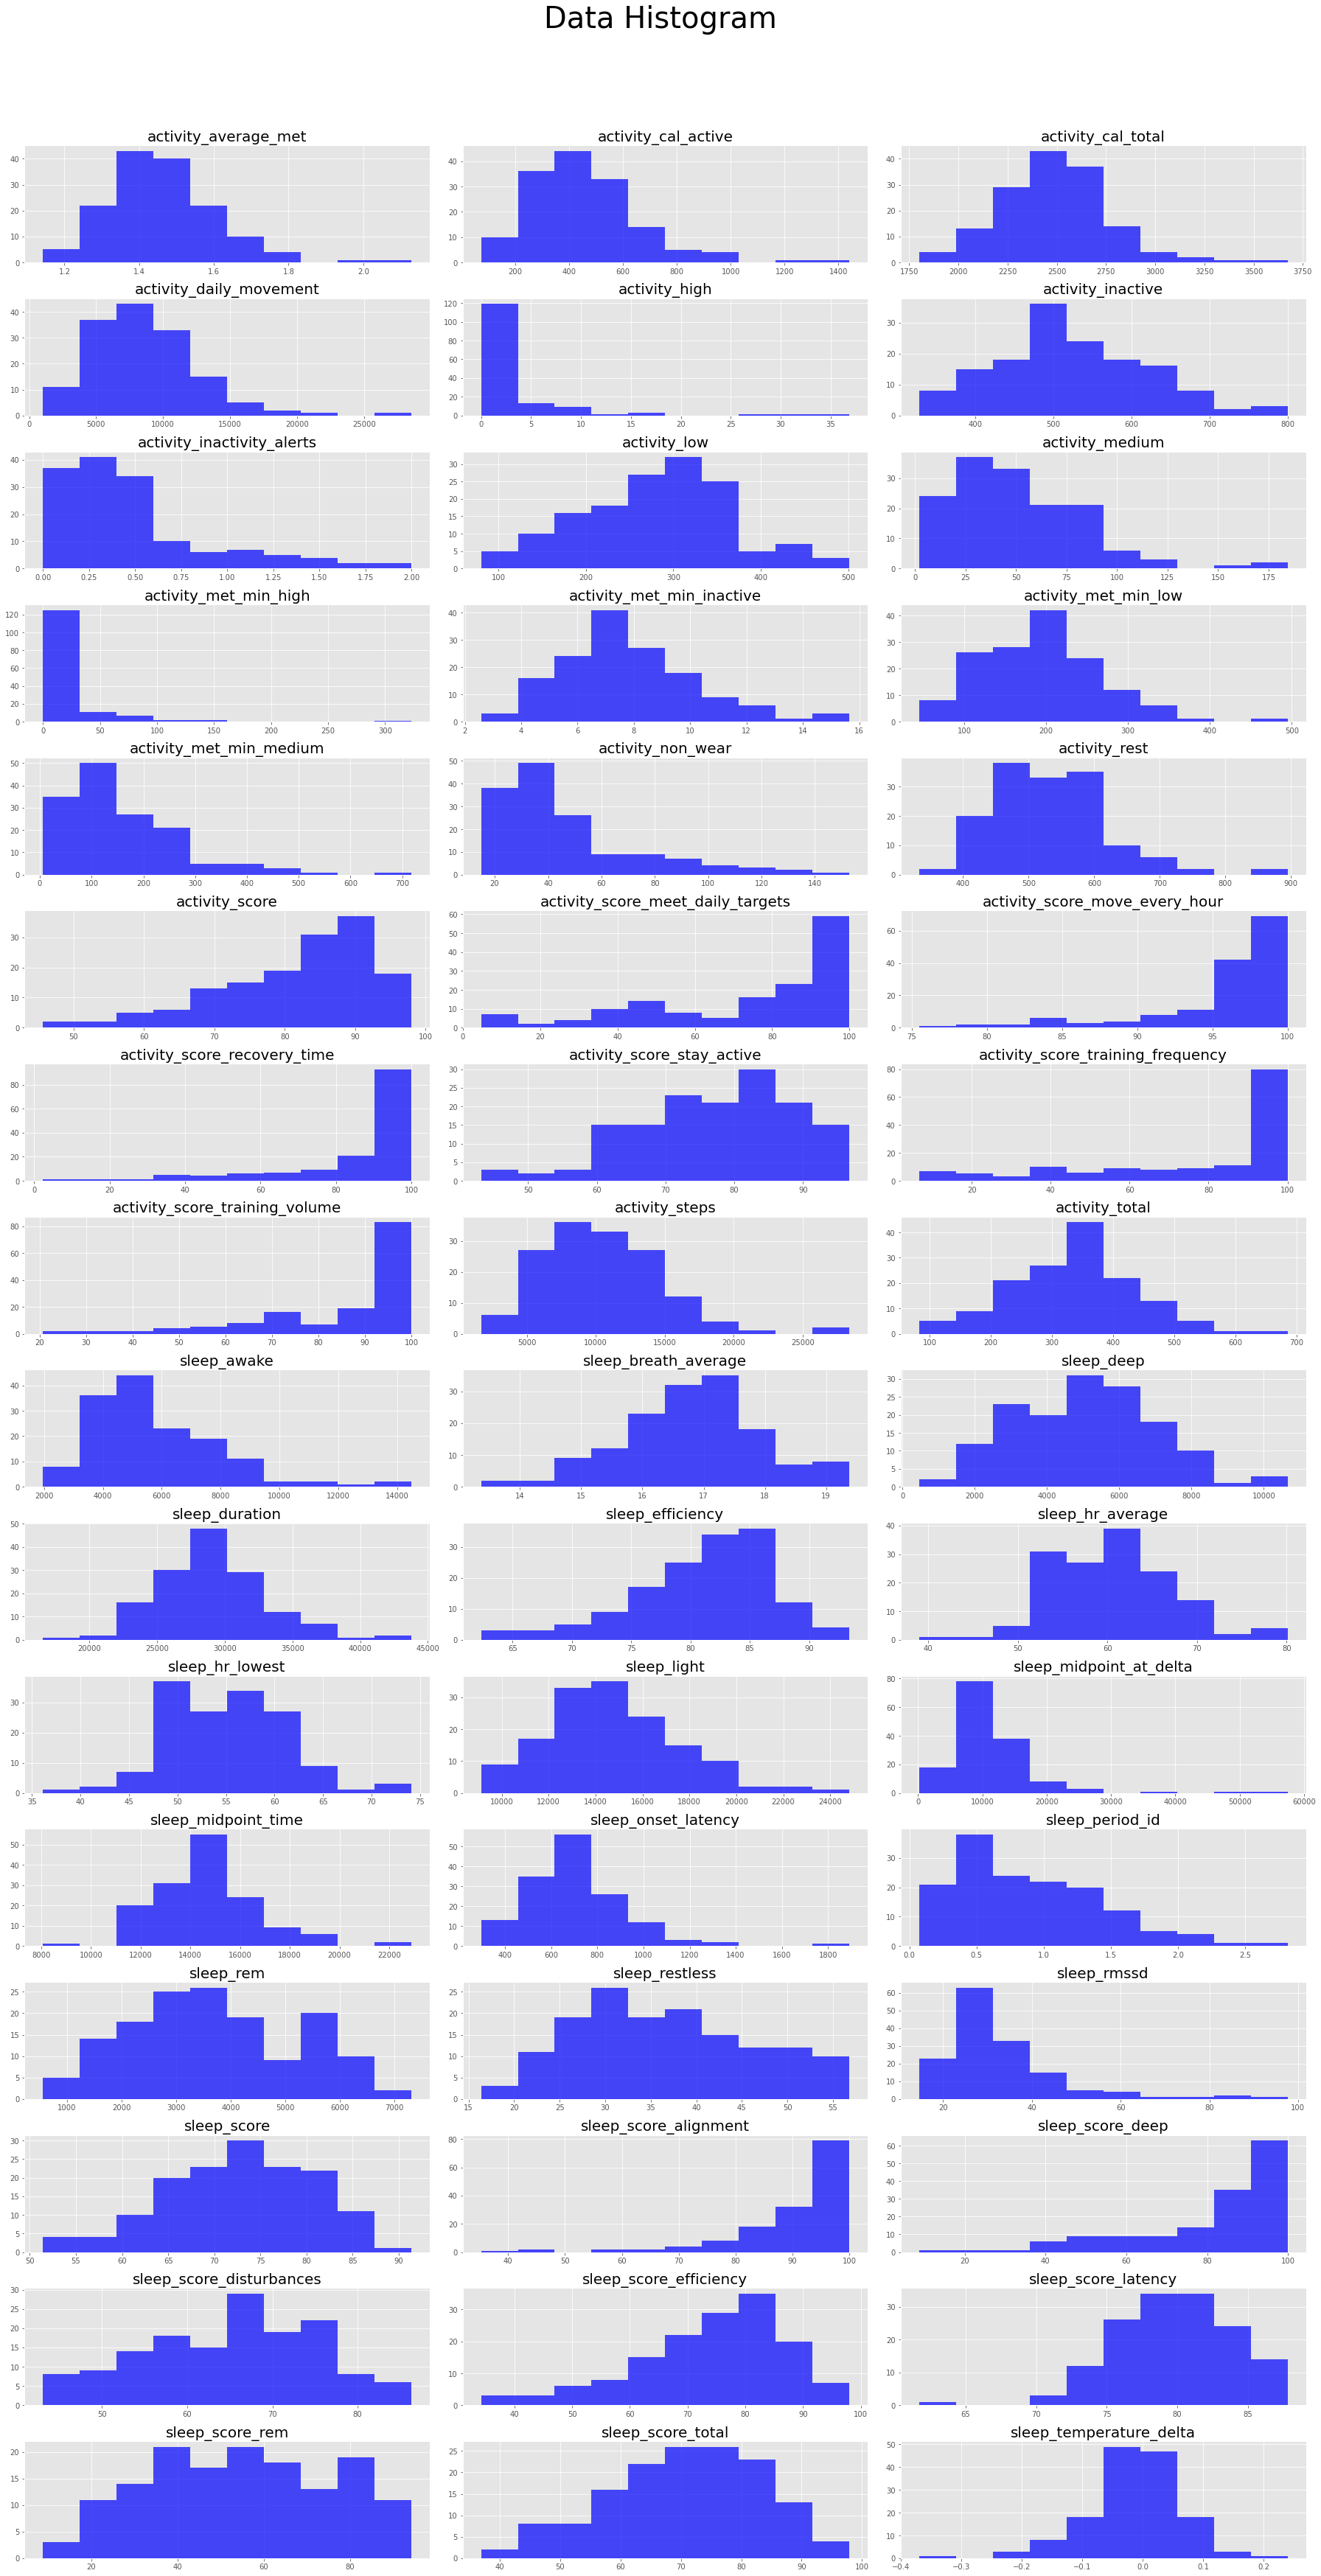

In [79]:
#data_activity = input_data_X.drop(['activity_met_1min', 'activity_class_5min'], axis=1)

plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,50))
plt.suptitle("Data Histogram", fontsize=40)

cols = input_data_X.columns
for i in range(len(cols)):
    plt.subplot(16,3,i+1)
    plt.title(cols[i], fontsize=20)
    if len(input_data_X[cols[i]].unique()) > 20:
        plt.hist(input_data_X[cols[i]], color='b', alpha=0.7)
    else:
        temp = input_data_X[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

In [80]:
input_data_X['sleep_score_deep'] = np.sqrt(input_data_X['sleep_score_deep'])
input_data_X['sleep_score_alignment'] = np.sqrt(input_data_X['sleep_score_alignment'])
input_data_X['sleep_rmssd'] = np.log1p(input_data_X['sleep_rmssd'])
input_data_X['sleep_onset_latency'] = np.log1p(input_data_X['sleep_onset_latency'])
##input_data_X['sleep_midpoint_at_delta'] = np.log1p(input_data_X['sleep_midpoint_at_delta'])
input_data_X['activity_score_training_volume'] = np.sqrt(input_data_X['activity_score_training_volume'])


input_data_X['activity_high'] = np.log1p(input_data_X['activity_high'])



## RobustScaler

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

In [82]:
input_data_X

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
0,1.263,204.339,2209.597,3693.694,0.591,612.968,0.823,146.935,18.597,6.081,...,3.360,68.113,8.631,8.697,57.871,65.565,78.532,55.258,70.016,0.022
1,1.364,215.871,1799.894,4949.024,0.090,575.188,0.612,278.529,14.235,0.635,...,3.941,84.753,9.374,9.446,84.000,98.024,84.094,74.988,82.035,0.086
2,1.390,263.115,2404.231,3893.250,0.443,640.904,0.365,325.750,7.865,4.038,...,3.552,65.077,9.884,7.676,63.769,59.442,79.019,63.558,56.096,-0.045
3,1.480,498.376,2581.860,8869.140,0.543,469.968,0.710,316.484,49.118,5.054,...,3.580,74.935,9.454,9.889,73.409,88.527,82.226,39.280,69.075,-0.012
4,1.386,267.857,2103.743,5021.743,1.117,489.371,0.286,322.286,28.600,8.886,...,4.301,71.857,9.306,9.818,66.800,75.429,74.886,20.200,75.629,0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,1.362,287.139,2349.556,5117.833,1.108,733.306,0.472,189.056,28.056,15.222,...,3.008,52.722,9.703,6.272,44.111,36.139,82.361,38.944,48.889,0.165
144,1.570,608.596,2725.365,11269.288,2.408,573.096,0.231,309.442,62.577,76.077,...,3.458,74.077,8.873,9.570,73.673,82.019,77.942,62.096,67.923,0.042
145,1.560,595.812,2705.604,11232.688,1.984,607.688,0.542,295.438,65.083,46.833,...,3.573,60.333,9.411,9.302,57.062,44.229,84.625,29.604,52.458,-0.107
146,1.265,212.125,2221.250,3606.875,0.470,497.325,0.350,215.075,10.000,4.425,...,3.332,81.550,9.622,9.341,73.225,69.025,75.825,83.075,85.100,-0.004


In [83]:
Rscaler = RobustScaler()
result = Rscaler.fit_transform(input_data_X)
pd.options.display.float_format = '{:.3f}'.format
input_data_X_scaled = pd.DataFrame(result, columns=input_data_X.columns)

In [84]:
input_data_X_scaled

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
0,-1.057,-0.926,-0.875,-0.856,-0.311,0.871,1.150,-1.214,-0.619,-0.177,...,-0.204,-0.449,-1.989,-0.643,-0.490,-0.649,-0.243,0.008,-0.083,0.368
1,-0.474,-0.880,-2.157,-0.612,-0.856,0.547,0.615,-0.084,-0.723,-0.474,...,1.440,1.021,-0.594,0.067,1.134,1.372,0.753,0.558,0.619,1.174
2,-0.326,-0.691,-0.266,-0.817,-0.472,1.111,-0.011,0.322,-0.875,-0.288,...,0.340,-0.717,0.364,-1.611,-0.123,-1.030,-0.156,0.239,-0.896,-0.485
3,0.193,0.247,0.290,0.151,-0.364,-0.354,0.863,0.242,0.108,-0.233,...,0.418,0.154,-0.443,0.486,0.476,0.781,0.419,-0.437,-0.138,-0.061
4,-0.351,-0.672,-1.206,-0.598,0.261,-0.188,-0.214,0.292,-0.381,-0.024,...,2.459,-0.118,-0.722,0.420,0.065,-0.035,-0.896,-0.969,0.244,3.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,-0.488,-0.596,-0.437,-0.579,0.250,1.902,0.260,-0.852,-0.394,0.322,...,-1.200,-1.808,0.023,-2.942,-1.346,-2.481,0.443,-0.447,-1.317,2.177
144,0.711,0.687,0.739,0.618,1.663,0.530,-0.353,0.182,0.429,3.640,...,0.073,0.078,-1.535,0.184,0.492,0.376,-0.348,0.198,-0.206,0.623
145,0.651,0.636,0.677,0.611,1.202,0.826,0.436,0.061,0.488,2.046,...,0.399,-1.136,-0.525,-0.070,-0.540,-1.978,0.848,-0.707,-1.109,-1.262
146,-1.047,-0.895,-0.838,-0.873,-0.443,-0.120,-0.050,-0.629,-0.824,-0.267,...,-0.283,0.738,-0.129,-0.033,0.465,-0.433,-0.728,0.783,0.798,0.035


<AxesSubplot:>

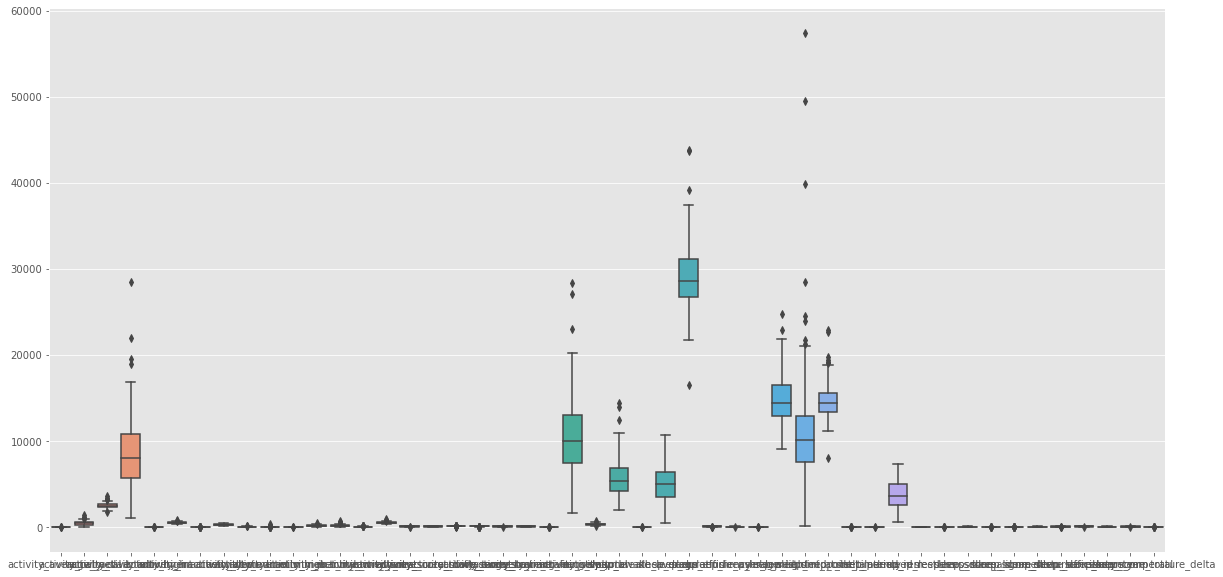

In [85]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=input_data_X)

<AxesSubplot:>

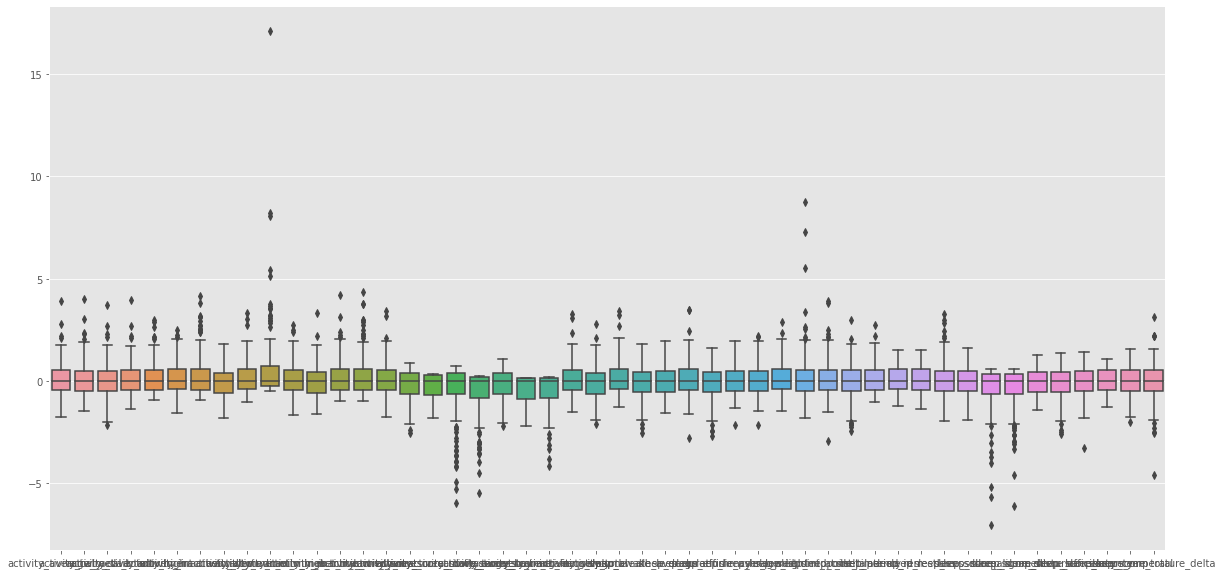

In [86]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=input_data_X_scaled)

In [87]:
input_data_X_scaled.describe()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
count,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,...,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000,148.000
mean,0.089,0.093,0.029,0.113,0.156,0.111,0.314,-0.061,0.158,0.641,...,0.084,-0.047,-0.398,-0.426,-0.046,-0.124,-0.024,0.004,-0.022,-0.051
std,0.815,0.841,0.876,0.796,0.839,0.829,1.057,0.729,0.780,1.983,...,0.928,0.694,1.199,1.127,0.624,0.802,0.737,0.593,0.741,1.017
min,-1.750,-1.447,-2.157,-1.374,-0.953,-1.569,-0.939,-1.787,-1.013,-0.509,...,-1.941,-1.923,-7.051,-6.094,-1.411,-2.600,-3.254,-1.287,-2.017,-4.588
25%,-0.443,-0.499,-0.508,-0.465,-0.457,-0.415,-0.423,-0.598,-0.410,-0.269,...,-0.504,-0.514,-0.656,-0.651,-0.549,-0.551,-0.500,-0.449,-0.481,-0.488
50%,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,...,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000
75%,0.557,0.501,0.492,0.535,0.543,0.585,0.577,0.402,0.590,0.731,...,0.496,0.486,0.344,0.349,0.451,0.449,0.500,0.551,0.519,0.512
max,3.925,4.005,3.699,3.979,2.995,2.471,4.140,1.829,3.329,17.106,...,3.280,1.605,0.582,0.586,1.278,1.372,1.416,1.095,1.546,3.117


In [88]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X_scaled, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 6. Modeling - ML

- Linear model
    - Logistic Linear Regression 
- Tree model 
    - RandomForest 
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [89]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 

model_rf = RandomForestClassifier()

model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )
model_lgbm = LGBMClassifier()

In [90]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4583,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 26]

#2 교차 검증 정확도 : 0.5,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#2 검증 세트 인덱스 : [13 24 25 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

#3 교차 검증 정확도 : 0.5417,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#3 검증 세트 인덱스 : [30 32 50 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 73 74 76]

#4 교차 검증 정확도 : 0.3478,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#4 검증 세트 인덱스 : [55 65 72 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 96 99]

#5 교차 검증 정확도 : 0.6087,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#5 검증 세트 인덱스 : [ 71  93  95  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]

## 평균 검증 정확도: 0.4913


In [91]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.3333,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 26]

#2 교차 검증 정확도 : 0.4583,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#2 검증 세트 인덱스 : [13 24 25 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

#3 교차 검증 정확도 : 0.4167,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#3 검증 세트 인덱스 : [30 32 50 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 73 74 76]

#4 교차 검증 정확도 : 0.3478,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#4 검증 세트 인덱스 : [55 65 72 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 96 99]

#5 교차 검증 정확도 : 0.5217,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#5 검증 세트 인덱스 : [ 71  93  95  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]

## 평균 검증 정확도: 0.41556


In [92]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X_scaled.iloc[train_index], input_data_X_scaled.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.3333,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 26]

#2 교차 검증 정확도 : 0.5,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#2 검증 세트 인덱스 : [13 24 25 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

#3 교차 검증 정확도 : 0.5833,  학습 데이터 크기 : 94,  검증 데이터 크기 : 24
#3 검증 세트 인덱스 : [30 32 50 51 52 53 54 56 57 58 59 60 61 62 63 64 66 67 68 69 70 73 74 76]

#4 교차 검증 정확도 : 0.3913,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#4 검증 세트 인덱스 : [55 65 72 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 94 96 99]

#5 교차 검증 정확도 : 0.5652,  학습 데이터 크기 : 95,  검증 데이터 크기 : 23
#5 검증 세트 인덱스 : [ 71  93  95  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117]

## 평균 검증 정확도: 0.47462


In [93]:
pred_rf = model_rf.predict(test_X)

pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

## KNN

전처리 및 정규화를 추가 할수록 좋아질 가능성 높음

In [94]:
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(tr_val_X, tr_val_y)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(tr_val_X, tr_val_y)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(test_X, test_y) 

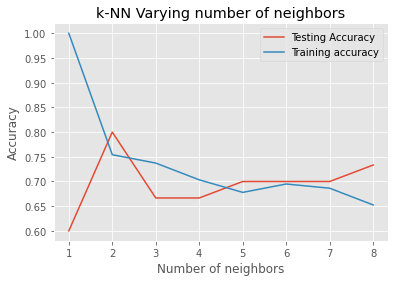

In [95]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [96]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(tr_val_X, tr_val_y)

KNeighborsClassifier(n_neighbors=2)

In [97]:
knn.score(test_X, test_y)

0.8

In [98]:
pred_knn = knn.predict(test_X)
print(classification_report(test_y, pred_knn))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       1.00      0.50      0.67         2
           2       1.00      0.38      0.55         8

    accuracy                           0.80        30
   macro avg       0.92      0.62      0.69        30
weighted avg       0.85      0.80      0.77        30



## deep learning process

### resnet

### Lstm

# 7. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [99]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [100]:
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.67      1.00      0.80         2
           2       0.78      0.88      0.82         8

    accuracy                           0.87        30
   macro avg       0.80      0.91      0.84        30
weighted avg       0.88      0.87      0.87        30



In [101]:
print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.67      1.00      0.80         2
           2       0.78      0.88      0.82         8

    accuracy                           0.87        30
   macro avg       0.80      0.91      0.84        30
weighted avg       0.88      0.87      0.87        30



In [102]:
print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.67      1.00      0.80         2
           2       0.70      0.88      0.78         8

    accuracy                           0.83        30
   macro avg       0.77      0.89      0.81        30
weighted avg       0.86      0.83      0.84        30

